<a href="https://colab.research.google.com/github/LeoFernanndes/notebooks/blob/master/titanic_data_manipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/LeoFernanndes/functions

fatal: destination path 'functions' already exists and is not an empty directory.


In [0]:
import pandas as pd
import numpy as np


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


url_train = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/titanic_%20train.csv'
url_test = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/titanic_test.csv'

columns_order = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived']

train = pd.read_csv(url_train).reindex(columns_order, axis= 1)
test = pd.read_csv(url_test).reindex(columns_order.remove('Survived'), axis= 1)

dataframe = train.append(test, sort= False).set_index(np.arange(0,1309), columns_order)
backup = dataframe.copy()
dataframe_ = dataframe.iloc[:891]

In [0]:
dataframe.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived'],
      dtype='object')

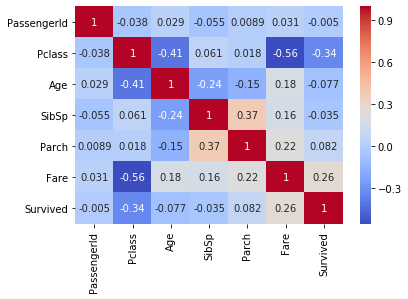

In [0]:
import seaborn as sns


g = sns.heatmap(dataframe.corr(),annot=True, cmap = "coolwarm")

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


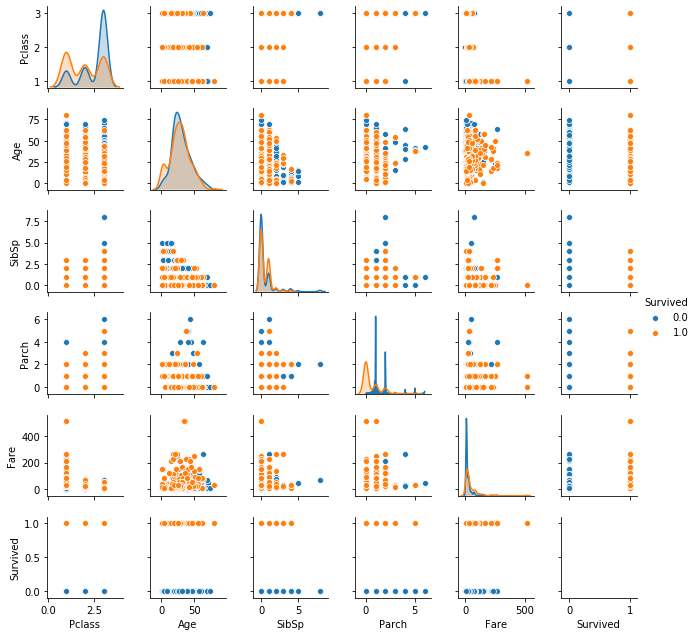

In [0]:
colunas = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived']

data = backup[colunas]


import seaborn as sns      
sns.pairplot(data, hue='Survived', size=1.5)

In [0]:
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

for feature in features:
  print(dataframe_.groupby(by= [feature]).mean()['Survived'].sort_values(ascending= False), '\n')

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64 

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64 

SibSp
1    0.535885
2    0.464286
0    0.345395
3    0.250000
4    0.166667
8    0.000000
5    0.000000
Name: Survived, dtype: float64 

Parch
3    0.600000
1    0.550847
2    0.500000
0    0.343658
5    0.200000
6    0.000000
4    0.000000
Name: Survived, dtype: float64 

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64 



In [0]:
dataframe.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0


In [0]:
# data cleaning and feature engineering


dataframe['Family'] = dataframe['Parch'] + dataframe['SibSp']



family_dict = {7: 0, 10: 0,
               5: 1, 4: 1,
               0: 2, 6: 2,
               1: 3, 2: 3, 3: 3}

dataframe['Family_'] = dataframe['Family'].map(family_dict)



dataframe['Sex'] = dataframe['Sex'].map({'female': 1,
                                         'male': 0})



dataframe['Fare'].fillna(dataframe['Fare'].median(), inplace= True)
dataframe['Embarked'].fillna('S', inplace= True)
dataframe['Cabin'].fillna('Unknown', inplace= True)
dataframe['Title'] = [name.split(',')[1].split('.')[0] for name in dataframe['Name']]
dataframe['Pclass'] = dataframe['Pclass'].fillna(dataframe['Pclass'].mode())
dataframe['Pclass_'] = dataframe['Pclass'].map({1: 3,
                                                2: 2,
                                                3: 1})


ages = dataframe.groupby(by= ['Title']).mean()['Age']
for title in ages.index:
  mask = dataframe['Title'] == title
  dataframe.loc[mask, 'Age'] = dataframe.loc[mask, 'Age'].fillna(value= dataframe.loc[dataframe['Title'] == title]['Age'].mean())



title_dict = {' Capt': 0, ' Don': 0, ' Jonkheer': 0, ' Rev': 0,
              ' Mr': 1, 'Dr': 1, ' Col': 1, ' Major': 1, ' Master': 1, ' Dona': 1,
              ' Miss': 2, ' Mrs': 2, ' Mme': 2, ' Sir': 2, ' Ms': 2, ' Lady': 2, ' Mlle': 2, ' the Countess': 2}

dataframe['Title_n'] = dataframe['Title'].copy().map(title_dict)



bins = [0, 12, 24, 45, 60, dataframe['Age'].max()]
labels = ['Child', 'Young Adult', 'Adult','Older Adult','Senior']
dataframe['Age_'] = pd.cut(dataframe["Age"], bins, labels = labels)



bins = [0, 8, 16, 24, 32, dataframe['Fare'].max()]
labels = ['low_price', 'tier2', 'tier3','tier4','high_price']
dataframe['Fare_'] = pd.cut(dataframe['Fare'], bins, labels = labels)

In [0]:
dataframe.dtypes
dataframe.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Family,Family_,Title,Pclass_,Title_n,Age_,Fare_
0,1,3,"Braund, Mr. Owen Harris",0,22.000000,1,0,A/5 21171,7.2500,Unknown,S,0.0,1,3,Mr,1,1.0,Young Adult,low_price
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.000000,1,0,PC 17599,71.2833,C85,C,1.0,1,3,Mrs,3,2.0,Adult,high_price
2,3,3,"Heikkinen, Miss. Laina",1,26.000000,0,0,STON/O2. 3101282,7.9250,Unknown,S,1.0,0,2,Miss,1,2.0,Adult,low_price
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.000000,1,0,113803,53.1000,C123,S,1.0,1,3,Mrs,3,2.0,Adult,high_price
4,5,3,"Allen, Mr. William Henry",0,35.000000,0,0,373450,8.0500,Unknown,S,0.0,0,2,Mr,1,1.0,Adult,tier2
5,6,3,"Moran, Mr. James",0,32.252151,0,0,330877,8.4583,Unknown,Q,0.0,0,2,Mr,1,1.0,Adult,tier2
6,7,1,"McCarthy, Mr. Timothy J",0,54.000000,0,0,17463,51.8625,E46,S,0.0,0,2,Mr,3,1.0,Older Adult,high_price
7,8,3,"Palsson, Master. Gosta Leonard",0,2.000000,3,1,349909,21.0750,Unknown,S,0.0,4,1,Master,1,1.0,Child,tier3
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.000000,0,2,347742,11.1333,Unknown,S,1.0,2,3,Mrs,1,2.0,Adult,tier2
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.000000,1,0,237736,30.0708,Unknown,C,1.0,1,3,Mrs,2,2.0,Young Adult,tier4


In [0]:
from functions import data_preprocessing


data_preprocessing.naive_data_preparation(dataframe)
#datraframe_ = dataframe.copy().loc[(dataframe['Survived'] == 1) | (dataframe['Survived'] == 0)]

In [0]:
dataframe.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Family,Family_,Title,Pclass_,Title_n,Age_,Fare_
0,1,3,155,0,22.0,1,0,720,7.2500,186,2,0.0,1,3,12,1,1.0,4,1
1,2,1,286,1,38.0,1,0,816,71.2833,106,0,1.0,1,3,13,3,2.0,0,0


In [0]:
from sklearn.model_selection import cross_val_score
from xgboost  import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB


'''
colunas = ['Sex', 'Ticket', 'Age', 'Fare', 'Name', 'PassengerId', 'Title',
       'Title_n', 'Cabin', 'Pclass', 'Fare_', 'Pclass_', 'Family',
       'Family_', 'Age_', 'SibSp', 'Embarked', 'Parch', 'Survived']
'''
colunas = ['Fare_', 'Age_', 'Title_n', 'Pclass_','Family_', 'Survived']


dataframe = dataframe.reindex(colunas, axis= 1)


dataframe_ = dataframe.iloc[:891]

clf = RandomForestClassifier(n_estimators= 100)

cross_val_score(clf,dataframe_[dataframe_.columns[:-1]], dataframe_['Survived'], cv= 10)

array([0.74444444, 0.84444444, 0.75280899, 0.83146067, 0.87640449,
       0.84269663, 0.87640449, 0.82022472, 0.87640449, 0.85227273])

In [0]:
dataframe_.head(2)

,Fare_,Age_,Title_n,Pclass_,Family_,Survived
0,1,4,1.0,1,3,0.0
1,0,0,2.0,3,3,1.0


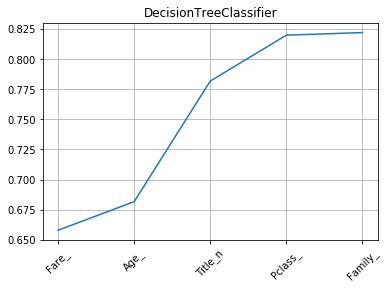

In [0]:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


clf = DecisionTreeClassifier()

data_preprocessing.classifier_accuracy_graph(dataframe_, clf, iterations= 200)

In [0]:
clf = DecisionTreeClassifier(max_depth= 5)
clf.fit(dataframe_[dataframe_.columns[:-1]], dataframe_['Survived'])

y_pred = clf.predict(dataframe[dataframe.columns[:-1]].iloc[891:])

In [0]:
pd.Series(y_pred).map({0.:0, 1.:1})
y_pred = pd.Series(y_pred).map({0.:0, 1.:1})
y_pred = list(y_pred)

In [0]:
df_featimp = pd.DataFrame({'feature': dataframe.columns[:-1],
                           'importance': clf.feature_importances_}).sort_values(by= ['importance'], ascending= False)

df_featimp['feature'].unique()                      

array(['Title_n', 'Pclass_', 'Age_', 'Family_', 'Fare_'], dtype=object)

In [0]:
envio = pd.DataFrame({'PassengerId': backup.iloc[891:]['PassengerId'],
                      'Survived': y_pred}).set_index(['PassengerId'])

from google.colab import files


envio.to_csv('titanic_submission_5.csv')